<a id='section6'></a>
# Index
1. [***Load and Check Package versions***](#section1)
2. [***Raw file import and truncation***](#section2) 
3. [***Spike Sorting***](#section3) 
4. [***Quality Metrics***](#section4)  
5. [***Saving the Notebook***](#section5)
----------------  
  
----------------  


<a id='section1'></a>
## ***(1) Load and Check Python Packages***
##### [back to top](#section6)

In [1]:
# Import required packages:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import neo
import OpenElectrophy as oe
import quantities as pq
import sys
import pip
from sklearn import mixture
from scipy import stats as st

#Hide warnings when importing data (optional)
import warnings
warnings.filterwarnings('ignore')
#Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
#use a plotting style in the notebook that is similar to ggplot2, see http://ggplot2.org/
plt.style.use('ggplot')
#plot the output of matplotlib commands in the notebook
%matplotlib inline

In [2]:
# Which version of Python is installed?
import sys
print(sys.version)

2.7.11 |Anaconda 2.5.0 (64-bit)| (default, Dec  6 2015, 18:08:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [3]:
# Which package versions are installed?
import pip
all_packages = pip.get_installed_distributions()
used_packages = ['pandas', 'numpy', 'matplotlib', 'sklearn', 'scipy', 'math', 'neo', 'OpenElectrophy', 'quantities',
               'pip', 'sys']

for entry in used_packages:
    for p in all_packages:
        if entry in str(p):
            print(str(p))

pandas 0.17.1
numpy 1.10.4
matplotlib 1.5.1
sklearn 0.0
scipy 0.17.0
neo 0.3.3
OpenElectrophy 0.3.4
quantities 0+unknown
pip 8.1.1


<a id='section2'></a>
## ***(2) Raw file import and truncation***
##### [back to top](#section6)

In [4]:
# make a directory if it does not exist
import os
if not os.path.exists("OUTPUT_FILES/"):
    os.makedirs("OUTPUT_FILES/")

In [5]:
# import a Spike2 file (CED)
filename='DATA_FILES/raw_data.smr'; r= neo.Spike2IO(filename)
bl = r.read()[0]; asig = bl.segments[0].analogsignals[0]
# keep the signal as a 16 bit float
asig = np.float16(asig)
# adjust for amplifier gain (in this example it is 20,000 and signals are microvolts)
asig = asig * 50 
pts = float(np.prod(asig.shape)); secs = pts/10000.0; mins = secs/60.0; hrs = mins/60
print('{}:\n===================='.format(filename.split('/')[-1]))
print('{} data points\n{} sec\n{} min\n{} hr\n20,000 Hz'.format(
    pts, secs, mins, hrs))

# save data to an HDF5 file type to share
# first remove any previously created files from running this cell
import os
try:
    os.remove("OUTPUT_FILES/raw_data.h5")
except OSError:
    pass

#Create new block
newfilename = "OUTPUT_FILES/raw_data.h5"

new_asig = asig
seg = neo.Segment()
seg.name = 'Test'
seg.description = 'New Segment'
seg.index = 0
seg.analogsignals = []
seg.analogsignals.append(new_asig)

rec = neo.RecordingChannel()
rec.analogsignals = []
rec.analogsignals.append(new_asig)

recg = neo.RecordingChannelGroup()
recg.recordingchannels = []
recg.recordingchannels.append(rec)
recg.name = 'Recording Channel'

b = neo.Block()
b.name = 'New Block'
b.segments = []
b.segments.append(seg)
b.recordingchannelgroups = []
b.recordingchannelgroups.append(recg)
w = neo.io.NeoHdf5IO(newfilename)
w.write_block(b)
w.close()

raw_data.smr:
2097214.0 data points
209.7214 sec
3.49535666667 min
0.0582559444444 hr
20,000 Hz


<a id='section3'></a>
## ***(3) Spike Sorting***
##### [back to top](#section6)

### a. file import and spikesorter initialization

In [6]:
#Open the HDF5 file that we created in the previous cell:
from OpenElectrophy.spikesorting import (generate_block_for_sorting, SpikeSorter)
filename = "OUTPUT_FILES/raw_data.h5"
r = neo.io.NeoHdf5IO(filename)
bl = r.read()[0]

#close the connection
r.close()

#Initiate the spike sorter object:
rcg = bl.recordingchannelgroups[0]
spikesorter = SpikeSorter(rcg)

### b. raw signal filtering

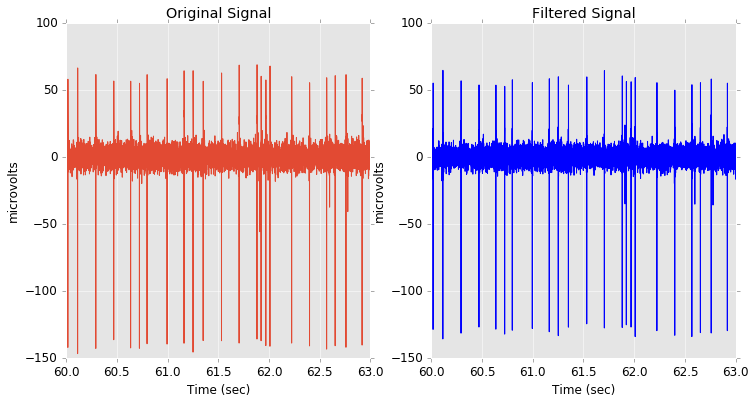

In [7]:
#Past filtering operations through spike sorter object:
spikesorter.DerivativeFilter()
spikesorter.ButterworthFilter(f_low = 200)

#Plot subsample the filtered and original signals
t_start = 60; t_stop = 63        #time window (s)
plt.figure(figsize= (12,6))
plt.subplot(1,2,1)
plt.plot(np.arange(t_start, t_stop, 1.0/10000),spikesorter.full_band_sigs[0][0][t_start*10000:t_stop*10000])
plt.title('Original Signal')
plt.xlabel('Time (sec)', fontsize = 12, color = 'black')
plt.ylabel('microvolts', fontsize = 12, color = 'black')
plt.xticks(fontsize = 12, color = 'black'); plt.yticks(fontsize = 12, color = 'black')
plt.subplot(1,2,2)
plt.plot(np.arange(t_start, t_stop, 1.0/10000),spikesorter.filtered_sigs[0][0][t_start*10000:t_stop*10000], color = 'b')
plt.title('Filtered Signal')
plt.xlabel('Time (sec)', fontsize = 12, color = 'black')
plt.ylabel('microvolts', fontsize = 12, color = 'black')
plt.xticks(fontsize = 12, color = 'black'); plt.yticks(fontsize = 12, color = 'black')

#save the image as SVG (optional)
plt.savefig('OUTPUT_FILES/signal_filter.svg')

### c. spike detection and alignment

In [8]:
#Spike detection: negative relative threshold (MAD of filtered signal * 6)
spikesorter.RelativeThresholdDetection(sign = '-', relative_thresh = 6.0)

#Align detected waveforms on peak, with 1.5 ms before and 1.5 ms after detection
spikesorter.AlignWaveformOnPeak(sign = '-', left_sweep = 1.5 *pq.ms, right_sweep = 1.5 * pq.ms)

recompute_cluster_center


Summary Statistics:
Recording duration: 209.7214 sec
Threshold: -28.9589390744
Number of Spikes: 2862 spikes
Spike Length: 3.1 ms
Multi-unit Freq: 13.6466760188 Hz


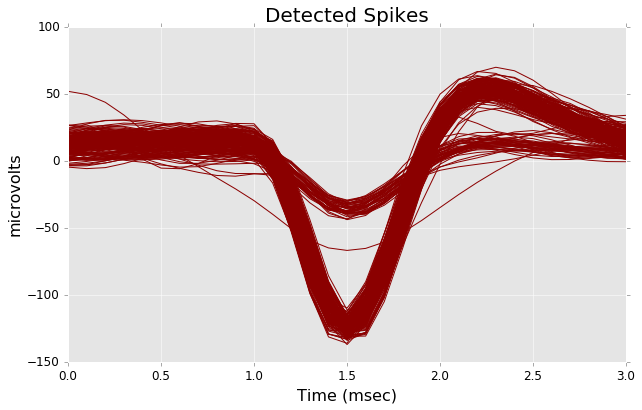

In [9]:
#Generate summary statistics for detected spikes
threshold = spikesorter.detection_thresholds[0][0]
spikes = spikesorter.nb_spikes
wavelength = float(spikesorter.left_sweep + spikesorter.right_sweep + 1)/10000 *1000
duration = np.array(spikesorter.seg_t_stop - spikesorter.seg_t_start)
spike_freq = spikes/duration
print('Summary Statistics:\n'+ '='*20)
print('Recording duration: {} sec\nThreshold: {}\nNumber of Spikes: {} spikes\nSpike Length: {} ms\nMulti-unit Freq: {} Hz'.format(
    float(duration), threshold,spikes, wavelength, float(spike_freq)))

#Visualize the detected spikes
frame= float(spikesorter.left_sweep + spikesorter.right_sweep + 1) #the number of points used in the spike length
plt.figure(figsize= (10,6));
plt.title('Detected Spikes', fontsize = 20);
step= int(math.floor(spikes/duration)) #used to randomly select a spike from each 1 sec bin to plot
for i in range(0,duration):
    plt.plot(np.arange(0.0,frame)/10,spikesorter.spike_waveforms[i*step].T, color = 'darkred');
    
plt.xlabel('Time (msec)', fontsize = 16, color = 'black');
plt.ylabel('microvolts', fontsize = 16, color = 'black')
plt.xticks(fontsize = 12, color = 'black'); plt.yticks(fontsize = 12, color= 'black')

#save the image as SVG (optional)
plt.savefig('OUTPUT_FILES/aligned_waveforms.svg')

### d. feature extraction

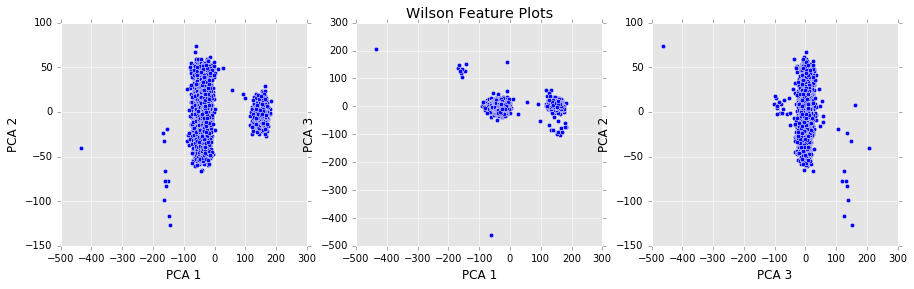

In [10]:
#Use Principle Component Analysis (PCA) to generate features for spikes
spikesorter.PcaFeature(n_components = 6)

#Visualize spikes in feature space
plt.figure(figsize =(15, 4))
plt.title('Wilson Feature Plots')
plt.subplot(1,3,1)
plt.scatter(spikesorter.waveform_features[:,0],spikesorter.waveform_features[:,1])
plt.xlabel('PCA 1', color = 'black'); plt.ylabel('PCA 2', color = 'black')
plt.xticks(color = 'black'); plt.yticks(color ='black')
plt.subplot(1,3,2)
plt.scatter(spikesorter.waveform_features[:,0],spikesorter.waveform_features[:,2])
plt.title('Wilson Feature Plots')
plt.xlabel('PCA 1', color = 'black'); plt.ylabel('PCA 3', color = 'black')
plt.xticks(color = 'black'); plt.yticks(color ='black')
plt.subplot(1,3,3)
plt.scatter(spikesorter.waveform_features[:,2],spikesorter.waveform_features[:,1])
plt.xlabel('PCA 3', color = 'black'); plt.ylabel('PCA 2', color = 'black')
plt.xticks(color = 'black'); plt.yticks(color ='black')
#save the image as SVG (optional)
plt.savefig('OUTPUT_FILES/features_noclusters.svg')

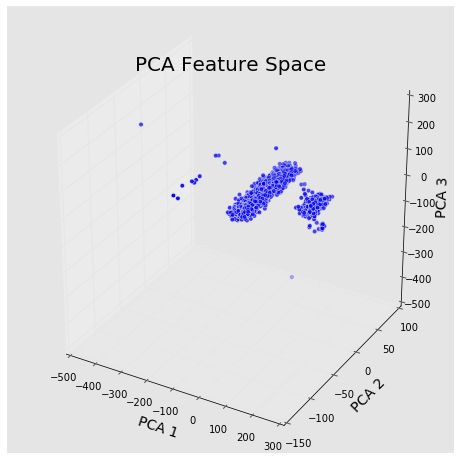

In [11]:
#Create a 3D visualization of the above data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(spikesorter.waveform_features[:,0], spikesorter.waveform_features[:,1],
           np.array(spikesorter.waveform_features[:,2]))
ax.set_title('PCA Feature Space')
ax.set_title('PCA Feature Space', fontsize = 20)
ax.set_xlabel('PCA 1', fontsize = 14, color = 'black'); ax.set_ylabel('PCA 2', fontsize = 14, color = 'black')
ax.set_zlabel('PCA 3', fontsize = 14, color = 'black')
ax.tick_params(axis='x', labelsize=10, labelcolor = 'black')
ax.tick_params(axis='y', labelsize=10, labelcolor = 'black')
ax.tick_params(axis='z', labelsize=10, labelcolor = 'black')
#save the image as SVG (optional)
plt.savefig('OUTPUT_FILES/3dfeatures_noclusters.svg')

### e. clustering

In [12]:
#IMPORTANT: CHANGE N TO REFLECT THE NUMBER OF EXPECTED CLUSTERS!
n = 3 #number of expected clusters

#Use Gaussian Mixture Model Expectation Maximization algorithm to cluster spikes:
spikesorter.SklearnGaussianMixtureEm(n_cluster = n, n_iter = 1000)

recompute_cluster_center
recompute_cluster_center


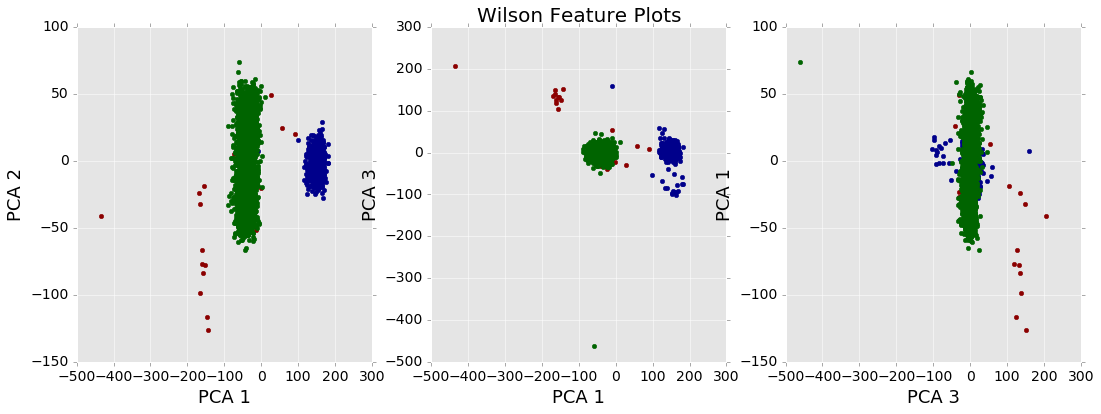

In [13]:
#Plot the same feature space above, except now with cluster assignment
spikesorter.refresh_cluster_names()
colors = ['darkred', 'darkblue', 'darkgreen', 'purple', 'darkorange', 'darkcyan', 'gold'] #add more colors as needed
c =matplotlib.colors.ColorConverter() #initialize color converter
for i in range(0, n):
    spikesorter.cluster_colors[i] = c.to_rgb(colors[i])

#Create counts list to store spike-cluster assignments, create features variable to contain the PCA features associated
#with each spike
counts = []
features = []
for i in range (0, len(spikesorter.cluster_names.items())):
    counts.append(np.where(spikesorter.spike_clusters == i)[0])
    features.append(spikesorter.waveform_features[counts[i],:])

#New reorganize our clusters by increasing size (i.e., smallest cluster is Cluster 0, etc.)
spikesorter.cluster_names.keys()
clusters = []
for i in range (0,n):
    clusters.append((str(spikesorter.cluster_names.keys()[i]), counts[i].size))
dtype = [('name', 'S10'), ('size', int)]
clusters = np.array(clusters, dtype = dtype)
clusters =np.sort(clusters, order = 'size')
new_features = [0]*n
for i in range(0, n):
    new_features[i] = features[int(clusters[i][0])]
features = new_features

#Re-create the Wilson Feature plots above, now with cluster assignment
plt.figure(figsize=(18,6))
plt.subplot(1,3, 1)
for i in range (0, len(features)):
    plt.scatter(features[i][:,0], features[i][:,1], c= spikesorter.cluster_colors[i],
                    edgecolor = spikesorter.cluster_colors[i])
    plt.xlabel('PCA 1', fontsize = 18, color = 'black'); plt.ylabel('PCA 2', fontsize = 18, color = 'black')
    plt.xticks(fontsize = 14, color = 'black'); plt.yticks(fontsize = 14, color = 'black')
    
plt.subplot(1,3,2)
for i in range (0, len(features)):
    plt.scatter(features[i][:,0], features[i][:,2], c = spikesorter.cluster_colors[i],
                    edgecolor = spikesorter.cluster_colors[i])
    plt.title('Wilson Feature Plots', fontsize = 20)
    plt.xlabel('PCA 1', fontsize = 18, color = 'black'); plt.ylabel('PCA 3', fontsize = 18, color = 'black')
    plt.xticks(fontsize = 14, color = 'black'); plt.yticks(fontsize = 14, color = 'black')
plt.subplot(1,3, 3)
for i in range (0, len(features)):
    plt.scatter(features[i][:,2], features[i][:,1], c = spikesorter.cluster_colors[i],
                    edgecolor = spikesorter.cluster_colors[i])
    plt.xlabel('PCA 3', fontsize = 18, color = 'black'); plt.ylabel('PCA 1', fontsize = 18, color = 'black')
    plt.xticks(fontsize = 14, color = 'black'); plt.yticks(fontsize = 14, color = 'black')
    
#save the image as SVG (optional)
plt.savefig('OUTPUT_FILES/features_clusters.svg')

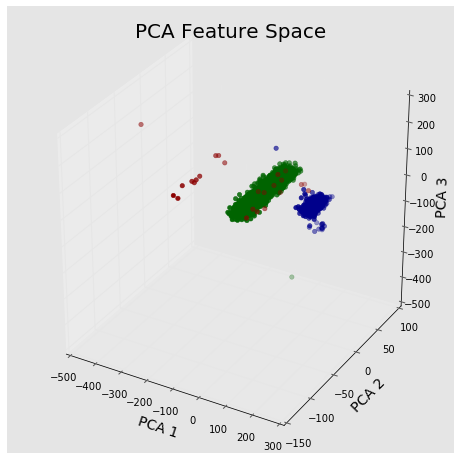

In [14]:
#Re-create 3D PCA feature space, this time with cluster assignment
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, projection='3d')

for i in range(0, len(features)):
    ax.scatter(features[i][:,0], features[i][:,1], np.array(features[i][:,2]), c = spikesorter.cluster_colors[i],
                                                            edgecolor = spikesorter.cluster_colors[i])
ax.set_title('PCA Feature Space', fontsize = 20)
ax.set_xlabel('PCA 1', fontsize = 14, color = 'black'); ax.set_ylabel('PCA 2', fontsize = 14, color = 'black')
ax.set_zlabel('PCA 3', fontsize = 14, color = 'black')
ax.tick_params(axis='x', labelsize=10, labelcolor = 'black')
ax.tick_params(axis='y', labelsize=10, labelcolor = 'black')
ax.tick_params(axis='z', labelsize=10, labelcolor = 'black')
#save the image as SVG (optional)
plt.savefig('OUTPUT_FILES/3dfeatures_clusters.svg')

### f. repopulate OpenElectrophy block and extract spike train data

In [15]:
#repopulate
rcg = spikesorter.populate_recordingchannelgroup()
for u, unit in enumerate(rcg.units):
    print int(clusters[u][0]), 'unit name', spikesorter.cluster_names.values()[int(clusters[u][0])]
    for s, seg in enumerate(rcg.block.segments):
        sptr = seg.spiketrains[u]
        print ' in Segment', s, 'has SpikeTrain with ', sptr.size


spikesorter.refresh_cluster_names()
colors = ['darkred', 'darkblue', 'darkgreen', 'purple', 'darkorange', 'darkcyan', 'gold'] #add more colors as needed
c =matplotlib.colors.ColorConverter() #initialize color converter
for i in range(0, n):
    spikesorter.cluster_colors[i] = c.to_rgb(colors[i])
    

1 unit name cluster #1
 in Segment 0 has SpikeTrain with  597
0 unit name cluster #0
 in Segment 0 has SpikeTrain with  25
2 unit name cluster #2
 in Segment 0 has SpikeTrain with  2240


### g. visualize waveforms, firing rate, and interspike interval (ISI)

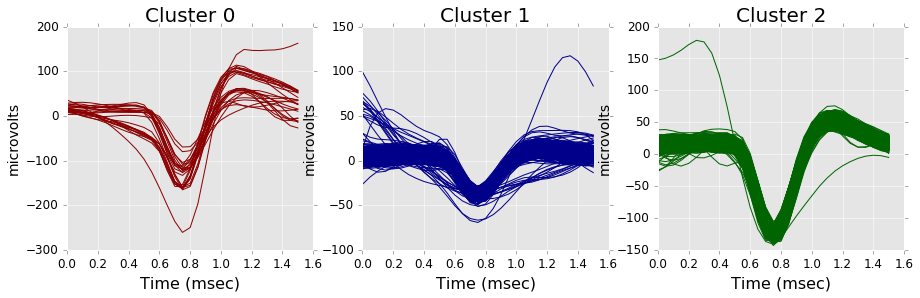

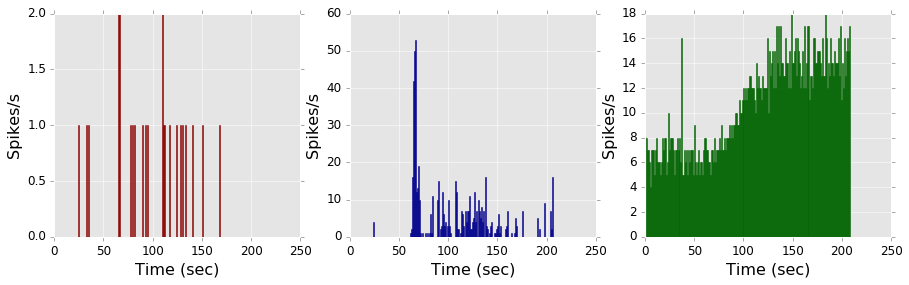

In [16]:
#Extract times from each unit into a list called timestamps
times = []
for i in range (0,len(rcg.units)):
    u = rcg.units[i].spiketrains[0]
    times.append(np.array(u.times))
    
#Do the same thing for waveforms
waveforms = []
for i in range (0,len(rcg.units)):
    u = rcg.units[i].spiketrains[0]
    waveforms.append(np.squeeze(u.waveforms))

#Reorganize waveforms and time based upon cluster size, with smallest cluster being Cluster 0
#New reorganize our clusters by increasing size (i.e., smallest cluster is Cluster 0, etc.)
new_waveforms = [0]*n; new_times = [0]*n
for i in range(0, n):
    new_waveforms[i] = waveforms[int(clusters[i][0])]
    new_times[i] = times[int(clusters[i][0])]
waveforms = new_waveforms
times = new_times

bounds = np.arange(int(math.floor(spikesorter.seg_t_start)), int(math.floor(spikesorter.seg_t_stop)))
plt.figure(figsize = (15, 4))
for i in range(0,n):
    plt.subplot(1, n, i+1)
    plt.plot(np.arange(0.0,frame)/20, waveforms[i].T, color = spikesorter.cluster_colors[i])
    plt.xlabel('Time (msec)', fontsize = 16, color = 'black')
    plt.ylabel('microvolts', fontsize = 14, color = 'black')
    plt.title('Cluster {}'.format(i), fontsize = 20)
    plt.xticks(fontsize = 12, color = 'black'); plt.yticks(fontsize = 12, color = 'black')
    
#save the image as SVG (optional)    
plt.savefig('OUTPUT_FILES/cluster_waveforms.svg')
plt.figure(figsize = (15, 4))
for i in range (0,n):
    plt.subplot(1, len(waveforms), i+1)
    plt.hist(times[i], bins= bounds, facecolor = spikesorter.cluster_colors[i], edgecolor=spikesorter.cluster_colors[i]);
    plt.xlabel('Time (sec)', fontsize = 16, color = 'black')
    plt.ylabel('Spikes/s', fontsize = 16, color = 'black')
    plt.xticks(fontsize = 12, color = 'black'); plt.yticks(fontsize = 12, color = 'black')
    
#save the image as SVG (optional)
plt.savefig('OUTPUT_FILES/cluster_firing.svg')

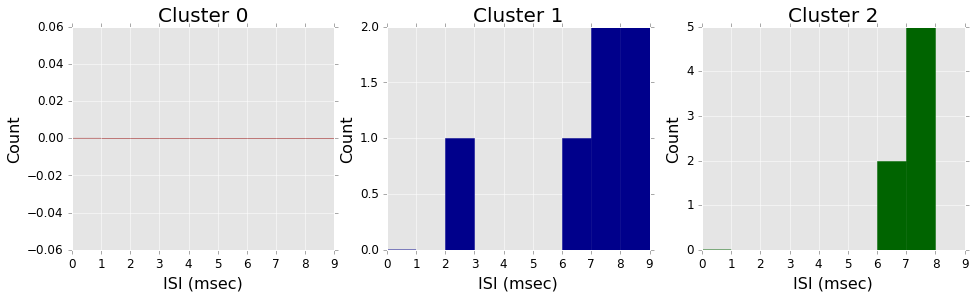

In [17]:
diff = []
for i in range(0, len(times)):
    diff.append(np.diff(times[i]))

bounds = np.arange(0, 0.01, 0.001)
plt.figure(figsize = (16, 4))
for i in range (0,n):
    plt.subplot(1, n, i+1)
    plt.hist(diff[i], bins= bounds, facecolor = spikesorter.cluster_colors[i], edgecolor=spikesorter.cluster_colors[i]);
    plt.xticks(np.arange(0, 0.01, 0.001), np.arange(10))
    plt.xlabel('ISI (msec)', fontsize = 16, color = 'black')
    plt.ylabel('Count', fontsize = 16, color = 'black')
    plt.title('Cluster {}'.format(i), fontsize = 20)
    plt.xticks(fontsize = 12, color = 'black'); plt.yticks(fontsize = 12, color = 'black')

#save the image as SVG (optional)
plt.savefig('OUTPUT_FILES/ISI_clusters.svg')

### write to a file

In [18]:
#write timestamps and waveforms of each cluster to a file,  if desired, with np.savetxt

for i in range(0, n):
    filename = 'OUTPUT_FILES/' + 'times_unit' + str(i) + '.txt'
    np.savetxt(filename, times[i])
    
for i in range(0,n):
    filename = 'OUTPUT_FILES/' + 'waveform_unit' + str(i) + '.txt'
    np.savetxt(filename, waveforms[i])

<a id='section4'></a>
## ***(4) quality metrics***
##### [back to top](#section6)

### a. the algorithms

In [19]:
#Refractory Violation: Calculates proportion of spikes that are false negative contaminations due to 
#refractory violations

def refractory(duration, refract_time, censor_time, unitnum):
    N = times[unitnum].size                                    #number of spikes in cluster
    rpvt = 2*(refract_time - censor_time)* N                   #amount of refractory time surrounding each spike
    T = duration                                               #length of recording (s)
    diff = np.diff(times[unitnum])                             #inter-spike intervals
    refract_violate = np.where(diff < refract_time)            #location of refractory violations
    rpv = refract_violate[0].size                              #number of refractory violations
    f = float(N) / float(T)                                    #firing frequency of unit
    f_r = float(rpv) / rpvt                                    #refractory frequency
    p = f_r / f
    
    if np.isnan(float(p)):
        p = 0
    if p > 1:
        p = 1
        
    return p

In [20]:
#Censored Spikes: Estimates proportion of spikes that were missed due to the censor period of the spike detection 
#algorithm combined during the activity of other units

def censor(duration, censor_time, unitnum):
    spkts = times[unitnum]
    spikes = 0
    for i in range(0, len(times)):
        spikes += times[i].shape[0]
    spikes -= spkts.shape[0]                                   #the total number of spikes in all other units
    cens = (spikes*censor_time)/float(duration)
    return cens       

In [21]:
#Threshold Cutoff: Estimates proportion of false negative spikes in a cluster due to the spikes falling under the
#detection threshold voltage

def thresh_cut(unitnum, thresh, graph):
    bins = 75.0;
    spkts = waveforms[unitnum] / thresh
    spkts = np.matrix(spkts)
    criteria = np.squeeze(np.asarray(spkts.max(1)))
    global_max = np.max(criteria)
    lims = np.linspace(1.0, global_max, bins + 1.0)
    x = lims + (lims[1] - lims[0])/2
    n, b = np.histogram(criteria, lims)
    n = np.insert(n, 74,0)
    
    #find the mode with an approximation
    num_samples = float(criteria.size)
    shift = np.round(num_samples * 0.05)
    k = np.sort(criteria)
    o = k[shift:criteria.size] - k[0:criteria.size - shift]
    w = np.argmin(o)
    m = k[np.round(w + np.float(shift)/2) - 1]

    #now approximate the stdev and mu from the mode
    num = 20
    init = np.sqrt(np.mean((m - criteria[criteria >= m])**2))
    st_guesses = np.linspace(init/2, init*2, num)
    m_guesses = np.linspace(m - init, max(m + init, 1), num)
    error = np.zeros((m_guesses.size, st_guesses.size))
    for i in range(m_guesses.size):
        for j in range(st_guesses.size):
            b = st.norm.pdf(x,m_guesses[i], st_guesses[j])
            a= b * np.sum(n) / np.sum(b)
            error[i, j] = np.sum(abs(a[:] - n[:]))

    #selecting the least error
    pos = np.argmin(error)
    jpos = pos % num
    if jpos == 0:
        jpos = num - 1
    kpos = np.ceil(float(pos) / num)
    stdev=  st_guesses[kpos]
    mu = m_guesses[jpos]
        
    p = st.norm.cdf(1.0, mu, stdev)
    return p

In [22]:
#Quantitative Overlap: Uses multivariate Gaussians to approximate two given clusters as two separate data distributions.
#Posterior probabilities are then used to approximate amount of overlap between clusters in a feature space
def overlap(unitnum1, unitnum2, graph):    
    
    spkts1 = waveforms[unitnum1]
    spkts2 = waveforms[unitnum2]
    
    N1 = spkts1.shape[0]
    N2 = spkts2.shape[0]

    spkts = np.vstack((spkts1, spkts2))
    spkts = np.matrix(spkts)

    data = sg.detrend(spkts, type = 'constant', axis = 0)
    u , s, v = np.linalg.svd(data, full_matrices = 0, compute_uv = 1)
    proj = data * np.matrix(v.T)
    cumvals = np.cumsum(s)
    threshold = np.sum(s) * 0.98
    num_dims = np.where(cumvals < threshold)[-1][-1]

    w1 = proj[0:N1, 0:num_dims]
    w2 = proj[N1:N1+N2, 0:num_dims]
    g = mixture.GMM(n_components=2, covariance_type= 'full')
    g.weights_ = np.array([float(N1)/(N1 + N2), float(N2)/(N1 + N2)])
    g.fit(np.vstack((w1, w2)))
    g.covars_[0] = np.cov(w1, rowvar = 0); g.covars_[1] = np.cov(w2, rowvar = 0)
    g.means_[0,:] = np.mean(w1, axis = 0); g.means_[1,:] = np.mean(w2, axis = 0)
    g.fit(np.vstack((w1, w2)))
    pr1 = g.predict_proba(w1)
    pr2 = g.predict_proba(w2)

    if np.mean(pr1[:,0]) + np.mean(pr2[:,1]) < 1:
        pr1 = pr1[:,np.arange(1,-1,-1)]
        pr2 = pr2[:,np.arange(1,-1,-1)]

    confusion = np.zeros((2,2))

    confusion[0,0] = np.mean(pr1[:,1])
    confusion[0,1] = np.sum(pr2[:,0]) / N1
    confusion[1,1] = np.mean(pr2[:,0])
    confusion[1,0] = np.sum(pr1[:,1]) / N2
    
    
    if graph:
        
        
        
        prob = np.concatenate((pr1[:,0], pr2[:,0]))
        r = prob.max() - prob.min()
        prob = (prob - prob.min()) / r
       
        
        
        plt.figure(figsize=(8,6))
        
        #fig = plt.figure(figsize=(8,6))
        #ax = fig.add_subplot(111, projection='3d')
        features_total  = np.vstack((w1, w2))
        s=plt.scatter(features_total[:,0], features_total[:,1], c = prob,edgecolors = 'none', cmap='jet')
        #ax.scatter(features_total[:,0], features_total[:,1], np.array(features_total[:,2]),
                   #c = prob,edgecolors = 'none', cmap='jet')
        plt.colorbar(s)
        
        plt.legend()
        plt.title('Quantitative Overlap')
        plt.show()
       
    return confusion

### b. Automatic Implementation

In [23]:
#Insert relevant parameters
duration = 1500.0          #duration of recording (s)
censor_time = 0.001        #duration of censor time for spike detection (s)
refract_time = 0.003       #duration of refractory period for a spike (s)
threshold = -28.958939075 #the threshold for spike detection
length = n                 #number of clusters

#Establish the cluster dictionary to contain all quality metrics for each (this will print as an empty table)

metrics = dict()
for i in range(length):
    metrics['cluster'+str(i)] = dict()
    metrics['cluster'+str(i)]['Threshold Negative'] = 0
    metrics['cluster'+str(i)]['Overlap Negative'] = 0
    metrics['cluster'+str(i)]['Censored Spikes'] = 0
    metrics['cluster'+str(i)]['Overlap Positive'] = 0
    metrics['cluster'+str(i)]['Refractory Violation'] = 0
pd.DataFrame(metrics)

,cluster0,cluster1,cluster2
Censored Spikes,0,0,0
Overlap Negative,0,0,0
Overlap Positive,0,0,0
Refractory Violation,0,0,0
Threshold Negative,0,0,0


In [24]:
#Run Validation Metrics, except for Gaussian Overlap:
for i in range(length):
    metrics['cluster' + str(i)]['Censored Spikes'] = censor(duration, censor_time, i)
    metrics['cluster' + str(i)]['Refractory Violation'] = refractory(duration, refract_time,censor_time , i)
    metrics['cluster' + str(i)]['Threshold Negative'] = thresh_cut(i, threshold, False)

#Run Gaussian Overlap for Combinations of Clusters:
clus=list(range(length))
for i in range(length):
    other_clus = clus[:]
    other_clus.remove(i)
    for j in other_clus:
        confusion = overlap(i, j, False)
        metrics['cluster' + str(i)]['Overlap Positive'] += confusion[0,0]
        metrics['cluster' + str(i)]['Overlap Negative'] += confusion[0,1]
        
m= pd.DataFrame(metrics)
m

,cluster0,cluster1,cluster2
Censored Spikes,0.001891,0.001510,4.146667e-04
Overlap Negative,0.558040,0.001675,1.339566e-03
Overlap Positive,0.120025,0.000031,6.666332e-03
Refractory Violation,0.000000,1.000000,0.000000e+00
Threshold Negative,0.000146,0.299800,9.170019e-13


In [25]:
#make the above table more visually appealing:
y = np.round(m,decimals=4)
y = pd.DataFrame(y.values*100, columns=y.columns, index=y.index)
y['cluster0'] = y['cluster0'].astype(str) + '%'
y['cluster1'] = y['cluster1'].astype(str) + '%'
y['cluster2'] = y['cluster2'].astype(str) + '%'
y

,cluster0,cluster1,cluster2
Censored Spikes,0.19%,0.15%,0.04%
Overlap Negative,55.8%,0.17%,0.13%
Overlap Positive,12.0%,0.0%,0.67%
Refractory Violation,0.0%,100.0%,0.0%
Threshold Negative,0.01%,29.98%,0.0%


In [26]:
#Finally, sum the errors to get a total false positive and false negative error for each cluster
total_error = dict()
for i in range(length):
    total_error['cluster'+str(i)] = dict()
    total_error['cluster'+str(i)]['Positive Error'] = 0
    total_error['cluster'+str(i)]['Negative Error'] = 0

for i in range(length):
    total_error['cluster'+str(i)]['Positive Error'] = metrics['cluster'+str(i)]['Overlap Positive'] + metrics['cluster'+ str(i)]['Refractory Violation']
    total_error['cluster'+str(i)]['Negative Error'] = metrics['cluster'+str(i)]['Overlap Negative'] + metrics['cluster'+str(i)]['Censored Spikes'] + metrics['cluster'+str(i)]['Threshold Negative']

te = pd.DataFrame(total_error)
te

,cluster0,cluster1,cluster2
Negative Error,0.560077,0.302985,0.001754
Positive Error,0.120025,1.000031,0.006666


In [27]:
#make the above table more visually appealing:
y = np.round(te,decimals=4)
y = pd.DataFrame(y.values*100, columns=y.columns, index=y.index)
y['cluster0'] = y['cluster0'].astype(str) + '%'
y['cluster1'] = y['cluster1'].astype(str) + '%'
y['cluster2'] = y['cluster2'].astype(str) + '%'
y

,cluster0,cluster1,cluster2
Negative Error,56.01%,30.3%,0.18%
Positive Error,12.0%,100.0%,0.67%


In [28]:
# get total percentage errors for each cluster
te.sum()*100

cluster0     68.010216
cluster1    130.301619
cluster2      0.842056
dtype: float64

<a id='section5'></a>
## ***(5) Saving the Notebook ***
##### [back to top](#section6)

In [29]:
# grabbing the name of the current notebook and printing the name
# if the print statement does not work, rerun the code for the following 3 cells

In [30]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NotebookName = '" + IPython.notebook.notebook_name + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [31]:
print(NotebookName)

Spike-Sorting.ipynb


In [32]:
## Saving the notebook to html
import os
import subprocess
subprocess.call('jupyter nbconvert '+NotebookName,shell=True)

0